In [31]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

EJ = 60
EC = 1
ng = 0
N = 2

n_vals = np.arange(-N, N+1)
dim_qubit = len(n_vals)

n_op = Qobj(np.diag(n_vals), dims=[[dim_qubit], [dim_qubit]])
shift_right = Qobj(np.diag(np.ones(dim_qubit - 1), 1), dims=[[dim_qubit], [dim_qubit]])
shift_left = shift_right.dag()
cos_phi = (shift_right + shift_left) / 2

H_transmon = 4 * EC * (n_op - ng)**2 - EJ * cos_phi

eigenenergies = H_transmon.eigenenergies()

print("Transmon energy levels:")
for i, E in enumerate(eigenenergies[:3]):
    print(f"Level {i}: {E:.4f} GHz")

f01_a = eigenenergies[1] - eigenenergies[0]
f12 = eigenenergies[2] - eigenenergies[1]
print(f"\nf01 = {f01_a:.4f} GHz")
print(f"f12 = {f12:.4f} GHz")
print(f"Anharmonicity = {f12 - f01_a:.4f} GHz")


Transmon energy levels:
Level 0: -47.7818 GHz
Level 1: -20.5941 GHz
Level 2: 10.5274 GHz

f01 = 27.1877 GHz
f12 = 31.1215 GHz
Anharmonicity = 3.9338 GHz


In [32]:
omega_r = 7
n_res = 10
a = destroy(n_res)
H_resonator = omega_r * a.dag() * a

H_total = tensor(H_transmon, qeye(n_res)) + tensor(qeye(dim_qubit), H_resonator)

g = 5.0

evals, evecs = H_transmon.eigenstates()
proj_01 = evecs[0] * evecs[1].dag()
H_int = g * (tensor(proj_01.dag(), a) + tensor(proj_01, a.dag()))

H_total += H_int

eigenenergies_coupled = H_total.eigenenergies()

print("Hybridized energy levels (lowest 6):")
for i, E in enumerate(eigenenergies_coupled[:6]):
    print(f"Level {i}: {E:.4f} GHz")

f01_b = eigenenergies_coupled[1] - eigenenergies_coupled[0]
f12 = eigenenergies_coupled[2] - eigenenergies_coupled[1]
anharmonicity = f12 - f01_b

print(f"\nQubit transition frequency f01: {f01_b:.4f} GHz")
print(f"Second transition frequency f12: {f12:.4f} GHz")
print(f"Anharmonicity (f12 - f01): {anharmonicity:.4f} GHz")


Hybridized energy levels (lowest 6):
Level 0: -47.7818 GHz
Level 1: -41.9523 GHz
Level 2: -36.0122 GHz
Level 3: -29.9878 GHz
Level 4: -23.8966 GHz
Level 5: -19.4236 GHz

Qubit transition frequency f01: 5.8295 GHz
Second transition frequency f12: 5.9402 GHz
Anharmonicity (f12 - f01): 0.1107 GHz


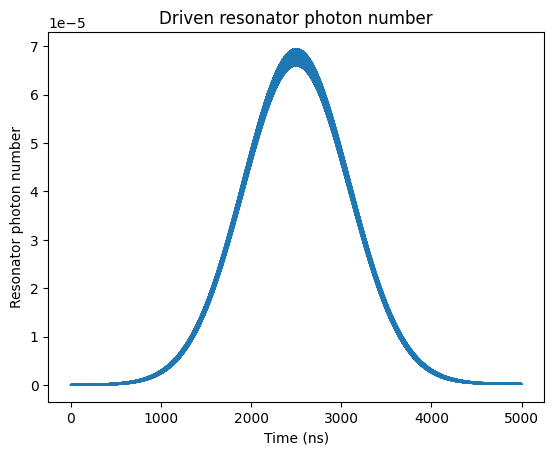

In [ ]:
drive_amp = 0.05        
drive_freq = omega_r       
drive_duration = 5000      
tlist = np.linspace(0, drive_duration, 50000l)

def gaussian_pulse(t, args):
    t0 = drive_duration / 2
    sigma = drive_duration / 6
    return drive_amp * np.exp(-(t - t0)**2 / (2 * sigma**2))

H_drive = [tensor(qeye(dim_qubit), a + a.dag()), gaussian_pulse]

psi0 = tensor(H_transmon.groundstate()[1], basis(n_res, 0))

c_ops = []

H_qubit = tensor(H_transmon, qeye(n_res))
H_res = tensor(qeye(dim_qubit), H_resonator)
H_full = H_qubit + H_res + H_int

drive_op = tensor(qeye(dim_qubit), a + a.dag())

H_total = [H_full, [drive_op, gaussian_pulse]]


result = mesolve(H_total, psi0, tlist, c_ops, [tensor(qeye(dim_qubit), a.dag() * a)])

plt.plot(tlist, result.expect[0])
plt.xlabel('Time (ns)')
plt.ylabel('Resonator photon number')
plt.title('Driven resonator photon number')
plt.show()




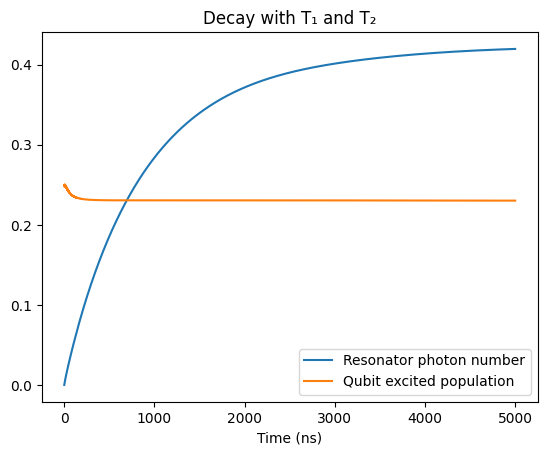

In [34]:
T1 = 30  # relaxation time in ns
T2 = 40  # dephasing time in ns

gamma1 = 1 / T1  # relaxation rate
gamma_phi = 1 / T2 - 0.5 / T1  # pure dephasing rate

from qutip import destroy

sm_qubit = destroy(dim_qubit)  # lowering operator in transmon space
sm = tensor(sm_qubit, qeye(n_res))

proj_0 = basis(dim_qubit, 0) * basis(dim_qubit, 0).dag()
proj_1 = basis(dim_qubit, 1) * basis(dim_qubit, 1).dag()
sz_qutrit = proj_1 - proj_0
sz = tensor(sz_qutrit, qeye(n_res))

c_ops = [np.sqrt(gamma1) * sm]

if gamma_phi > 0:
    c_ops.append(np.sqrt(gamma_phi) * sz)

result = mesolve(H_total, psi0, tlist, c_ops, [
    tensor(qeye(dim_qubit), a.dag() * a),  # resonator photon number
    tensor(basis(dim_qubit,1) * basis(dim_qubit,1).dag(), qeye(n_res))  # qubit excited state population
])

plt.plot(tlist, result.expect[0], label="Resonator photon number")
plt.plot(tlist, result.expect[1], label="Qubit excited population")
plt.xlabel("Time (ns)")
plt.legend()
plt.title("Decay with T₁ and T₂")
plt.show()






In [40]:
omega_q = f01_a  
omega_r = 7.0  

Delta = omega_q - omega_r
print(Delta)
chi = g**2 / Delta  

print(f"Dispersive shift = {chi:.4f} GHz")



20.187710568580066
Dispersive shift = 1.2384 GHz


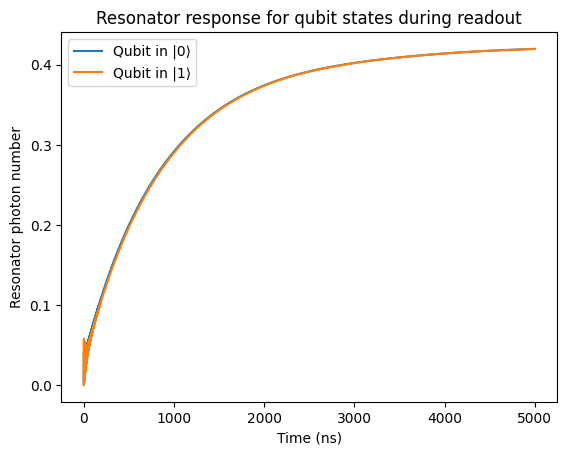

In [ ]:
psi0_0 = tensor(basis(dim_qubit, 0), basis(n_res, 0))
psi0_1 = tensor(basis(dim_qubit, 1), basis(n_res, 0))

result_0 = mesolve(H_total, psi0_0, tlist, c_ops, [tensor(qeye(dim_qubit), a.dag() * a)])
result_1 = mesolve(H_total, psi0_1, tlist, c_ops, [tensor(qeye(dim_qubit), a.dag() * a)])

plt.plot(tlist, result_0.expect[0], label="Qubit in |0⟩")
plt.plot(tlist, result_1.expect[0], label="Qubit in |1⟩")
plt.xlabel("Time (ns)")
plt.ylabel("Resonator photon number")
plt.title("Resonator response for qubit states during readout")
plt.legend()
plt.show()


